In [1]:
import pathlib
from SEIR import seir, setup, file_paths
from SEIR.utils import config, Timer
from SEIR.profile import profile_options
from Outcomes import outcomes
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import matplotlib.pyplot as plt

config_path = '../COVID19_USA/config_SMH_R7_lowVac_highVar_drop_incidC_CA-WA.yml'

config.set_file(config_path)

spatial_config = config["spatial_setup"]
spatial_base_path = pathlib.Path('../COVID19_USA/' + spatial_config["base_path"].get())
scenario = 'inference'
deathrate = 'med'
stoch_traj_flag = False # Truthy: stochastic simulation, Falsy: determnistic mean of the binomial draws
index = 1
run_id='R7_lowVac_highVar_drop_incidC_CA-WA'
prefix = 'USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/'

nsimtd = 1

nsim = 1
interactive = False
write_csv = False
write_parquet = True


### Profile configuration
import cProfile
import pstats
from functools import wraps

### Logger configuration
import logging
import os
logging.basicConfig(level=os.environ.get('COVID_LOGLEVEL', 'INFO').upper())
logger = logging.getLogger()
handler = logging.StreamHandler()
# '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
formatter = logging.Formatter("%(asctime)s [%(filename)s:%(lineno)s - %(funcName)20s() ] %(message)s")

handler.setFormatter(formatter)
print()

cp = 'I1'


dt1 = config["dt"].as_number()
s = setup.Setup(
    setup_name=config["name"].get() + "_" + str(scenario),
    spatial_setup=setup.SpatialSetup(
        setup_name=spatial_config["setup_name"].get(),
        geodata_file=spatial_base_path / spatial_config["geodata"].get(),
        mobility_file=spatial_base_path / spatial_config["mobility"].get(),
        popnodes_key=spatial_config["popnodes"].get(),
        nodenames_key=spatial_config["nodenames"].get()
    ),
    nsim=nsim,
    npi_scenario=scenario,
    npi_config=config["interventions"]["settings"][scenario],
    seeding_config=config["seeding"],
    parameters_config=config["seir"]["parameters"],
    ti=config["start_date"].as_date(),
    tf=config["end_date"].as_date(),
    interactive=interactive,
    write_csv=write_csv,
    write_parquet=write_parquet,
    dt=dt1,
    first_sim_index = index,
    in_run_id = run_id,
    in_prefix = prefix,
    out_run_id = run_id,
    out_prefix = prefix
)

print(f"""
>> Running ***{'STOCHASTIC' if stoch_traj_flag else 'DETERMINISTIC'}*** SEIR and Outcomes modules;
>> Setup {s.setup_name}; ti: {s.ti}; tf: {s.tf}; Scenario SEIR: {scenario}; Scenario Outcomes: {deathrate};
>> index: {s.first_sim_index}; run_id: {run_id}, prefix: {prefix};""")

setup_name = s.setup_name

#@profile()
def onerun_OUTCOMES_loadID(index):
    with Timer('onerun_OUTCOMES_loadID'):
        outcomes.onerun_delayframe_outcomes_load_hpar(config,
                                                        int(index), run_id, prefix, # input
                                                        int(index), run_id, prefix,  # output
                                                        deathrate, stoch_traj_flag)
    return 1

#@profile()                                                   
def onerun_OUTCOMES(index):
    with Timer('onerun_OUTCOMES'):
        outcomes.run_delayframe_outcomes(config,
                                            int(index), run_id, prefix, # input
                                            int(index), run_id, prefix, # output
                                            deathrate, nsim=1, n_jobs=1, stoch_traj_flag = stoch_traj_flag)
    return 1

#@profile()
def onerun_SEIR_loadID(sim_id2write, s, sim_id2load):
    with Timer('onerun_SEIR_loadID'):
        seir.onerun_SEIR_loadID(int(sim_id2write), s, int(sim_id2load), stoch_traj_flag)
    return 1

#@profile()
def onerun_SEIR(sim_id2write, s):
    with Timer('onerun_SEIR'):
        seir.onerun_SEIR(int(sim_id2write), s, stoch_traj_flag)
    return 1

df_dt1 = []
fn = 'model_output/seir/USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/000010000.R7_lowVac_highVar_drop_incidC_CA-WA.seir.parquet'
#fn = 'model_output/seir/USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/000000100.R7_lowVac_highVar_drop_incidC_CA-WA.seir.parquet'
for i in range (nsimtd):
    onerun_SEIR_loadID(10000, s, 1)
    #onerun_SEIR(100, s)
    df = pq.read_table(fn).to_pandas()
    df_dt1.append(df[df['comp']==cp].groupby('time').sum()['53000'])
    
df_dt1 = pd.concat(df_dt1, axis = 1)



>> Running ***DETERMINISTIC*** SEIR and Outcomes modules;
>> Setup USA_inference; ti: 2020-01-01; tf: 2022-01-01; Scenario SEIR: inference; Scenario Outcomes: med;
>> index: 1; run_id: R7_lowVac_highVar_drop_incidC_CA-WA, prefix: USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/;


INFO:root:[onerun_SEIR_loadID.NPI] completed in 0.6647801399230957 s
INFO:root:[onerun_SEIR_loadID.seeding] completed in 0.0036368370056152344 s
INFO:root:[onerun_SEIR_loadID.pdraw] completed in 0.015106916427612305 s
INFO:root:[onerun_SEIR_loadID.reduce] completed in 0.046637773513793945 s
INFO:root:[onerun_SEIR_loadID.compute] completed in 0.026517868041992188 s
INFO:root:[onerun_SEIR_loadID.postprocess] completed in 0.0269010066986084 s
INFO:root:[onerun_SEIR_loadID] completed in 0.7873528003692627 s


..........................s
(732, 2)
53000    0.402231
06000    0.357413
dtype: float64
53000    0.787792
06000    0.785079
dtype: float64
53000   -0.791460
06000   -0.858483
dtype: float64
---
(2925, 2)
[ 0.18176099  0.18176099  0.18176099 ... -0.54973496 -0.54973496
 -0.54973496]
[ 0.20681273  0.20681273  0.20681273 ... -0.24098723 -0.24098723
 -0.24098723]
[ 0.15670925  0.15670925  0.15670925 ... -0.8584827  -0.8584827
 -0.8584827 ]
..........................s
(732, 2)
53000    0.078661
06000    0.078661
dtype: float64
53000    0.3
06000    0.3
dtype: float64
53000    0.0
06000    0.0
dtype: float64
---
(2925, 2)
[0.  0.  0.  ... 0.3 0.3 0.3]
[0.  0.  0.  ... 0.3 0.3 0.3]
[0.  0.  0.  ... 0.3 0.3 0.3]
..........................s
(732, 2)
53000    0.01556
06000    0.01556
dtype: float64
53000    0.06
06000    0.06
dtype: float64
53000    0.0
06000    0.0
dtype: float64
---
(2925, 2)
[0.   0.   0.   ... 0.06 0.06 0.06]
[0.   0.   0.   ... 0.06 0.06 0.06]
[0.   0.   0.   ... 0.06 0.06 

In [2]:
dt2 = dt1/10
s = setup.Setup(
    setup_name=config["name"].get() + "_" + str(scenario),
    spatial_setup=setup.SpatialSetup(
        setup_name=spatial_config["setup_name"].get(),
        geodata_file=spatial_base_path / spatial_config["geodata"].get(),
        mobility_file=spatial_base_path / spatial_config["mobility"].get(),
        popnodes_key=spatial_config["popnodes"].get(),
        nodenames_key=spatial_config["nodenames"].get()
    ),
    nsim=nsim,
    npi_scenario=scenario,
    npi_config=config["interventions"]["settings"][scenario],
    seeding_config=config["seeding"],
    parameters_config=config["seir"]["parameters"],
    ti=config["start_date"].as_date(),
    tf=config["end_date"].as_date(),
    interactive=interactive,
    write_csv=write_csv,
    write_parquet=write_parquet,
    dt=dt2,
    first_sim_index = index,
    in_run_id = run_id,
    in_prefix = prefix,
    out_run_id = run_id,
    out_prefix = prefix
)

df_dt2 = []
fn = 'model_output/seir/USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/000010002.R7_lowVac_highVar_drop_incidC_CA-WA.seir.parquet'
#fn = 'model_output/seir/USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/000000100.R7_lowVac_highVar_drop_incidC_CA-WA.seir.parquet'
for i in range (nsimtd):
    onerun_SEIR_loadID(10002, s, 1)
    #onerun_SEIR(100, s)
    df = pq.read_table(fn).to_pandas()
    df_dt2.append(df[df['comp']==cp].groupby('time').sum()['53000'])
    
df_dt2 = pd.concat(df_dt2, axis = 1)

INFO:root:[onerun_SEIR_loadID.NPI] completed in 0.6656758785247803 s
INFO:root:[onerun_SEIR_loadID.seeding] completed in 0.0026760101318359375 s
INFO:root:[onerun_SEIR_loadID.pdraw] completed in 0.01680588722229004 s
INFO:root:[onerun_SEIR_loadID.reduce] completed in 0.051870107650756836 s


..........................s
(732, 2)
53000    0.403134
06000    0.358083
dtype: float64
53000    0.787792
06000    0.785079
dtype: float64
53000   -0.781214
06000   -0.827888
dtype: float64
---
(29241, 2)
[ 0.18176099  0.18176099  0.18176099 ... -0.54424486 -0.54424486
 -0.54424486]
[ 0.20681273  0.20681273  0.20681273 ... -0.26060163 -0.26060163
 -0.26060163]
[ 0.15670925  0.15670925  0.15670925 ... -0.82788809 -0.82788809
 -0.82788809]
..........................s
(732, 2)
53000    0.078661
06000    0.078661
dtype: float64
53000    0.3
06000    0.3
dtype: float64
53000    0.0
06000    0.0
dtype: float64
---
(29241, 2)
[0.  0.  0.  ... 0.3 0.3 0.3]
[0.  0.  0.  ... 0.3 0.3 0.3]
[0.  0.  0.  ... 0.3 0.3 0.3]
..........................s
(732, 2)
53000    0.01556
06000    0.01556
dtype: float64
53000    0.06
06000    0.06
dtype: float64
53000    0.0
06000    0.0
dtype: float64
---
(29241, 2)
[0.   0.   0.   ... 0.06 0.06 0.06]
[0.   0.   0.   ... 0.06 0.06 0.06]
[0.   0.   0.   ... 0.06 0

INFO:root:[onerun_SEIR_loadID.compute] completed in 0.2512688636779785 s
INFO:root:[onerun_SEIR_loadID.postprocess] completed in 0.025620222091674805 s
INFO:root:[onerun_SEIR_loadID] completed in 1.018568992614746 s


In [3]:
dt3 = dt1/5
s = setup.Setup(
    setup_name=config["name"].get() + "_" + str(scenario),
    spatial_setup=setup.SpatialSetup(
        setup_name=spatial_config["setup_name"].get(),
        geodata_file=spatial_base_path / spatial_config["geodata"].get(),
        mobility_file=spatial_base_path / spatial_config["mobility"].get(),
        popnodes_key=spatial_config["popnodes"].get(),
        nodenames_key=spatial_config["nodenames"].get()
    ),
    nsim=nsim,
    npi_scenario=scenario,
    npi_config=config["interventions"]["settings"][scenario],
    seeding_config=config["seeding"],
    parameters_config=config["seir"]["parameters"],
    ti=config["start_date"].as_date(),
    tf=config["end_date"].as_date(),
    interactive=interactive,
    write_csv=write_csv,
    write_parquet=write_parquet,
    dt=dt3,
    first_sim_index = index,
    in_run_id = run_id,
    in_prefix = prefix,
    out_run_id = run_id,
    out_prefix = prefix
)

df_dt3 = []
fn = 'model_output/seir/USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/000010003.R7_lowVac_highVar_drop_incidC_CA-WA.seir.parquet'
#fn = 'model_output/seir/USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/000000100.R7_lowVac_highVar_drop_incidC_CA-WA.seir.parquet'
for i in range (nsimtd):
    onerun_SEIR_loadID(10003, s, 1)
    #onerun_SEIR(100, s)
    df = pq.read_table(fn).to_pandas()
    df_dt3.append(df[df['comp']==cp].groupby('time').sum()['53000'])
    
df_dt3 = pd.concat(df_dt3, axis = 1)

INFO:root:[onerun_SEIR_loadID.NPI] completed in 0.6515951156616211 s
INFO:root:[onerun_SEIR_loadID.seeding] completed in 0.0023827552795410156 s
INFO:root:[onerun_SEIR_loadID.pdraw] completed in 0.02086806297302246 s
INFO:root:[onerun_SEIR_loadID.reduce] completed in 0.04261612892150879 s
INFO:root:[onerun_SEIR_loadID.compute] completed in 0.12476706504821777 s
INFO:root:[onerun_SEIR_loadID.postprocess] completed in 0.02519083023071289 s
INFO:root:[onerun_SEIR_loadID] completed in 0.8720371723175049 s


..........................s
(732, 2)
53000    0.403286
06000    0.356317
dtype: float64
53000    0.787792
06000    0.785079
dtype: float64
53000   -0.795175
06000   -0.893847
dtype: float64
---
(14621, 2)
[ 0.18176099  0.18176099  0.18176099 ... -0.57783268 -0.57783268
 -0.57783268]
[ 0.20681273  0.20681273  0.20681273 ... -0.26181828 -0.26181828
 -0.26181828]
[ 0.15670925  0.15670925  0.15670925 ... -0.89384708 -0.89384708
 -0.89384708]
..........................s
(732, 2)
53000    0.078661
06000    0.078661
dtype: float64
53000    0.3
06000    0.3
dtype: float64
53000    0.0
06000    0.0
dtype: float64
---
(14621, 2)
[0.  0.  0.  ... 0.3 0.3 0.3]
[0.  0.  0.  ... 0.3 0.3 0.3]
[0.  0.  0.  ... 0.3 0.3 0.3]
..........................s
(732, 2)
53000    0.01556
06000    0.01556
dtype: float64
53000    0.06
06000    0.06
dtype: float64
53000    0.0
06000    0.0
dtype: float64
---
(14621, 2)
[0.   0.   0.   ... 0.06 0.06 0.06]
[0.   0.   0.   ... 0.06 0.06 0.06]
[0.   0.   0.   ... 0.06 0

In [4]:
dt4 = 3/24
s = setup.Setup(
    setup_name=config["name"].get() + "_" + str(scenario),
    spatial_setup=setup.SpatialSetup(
        setup_name=spatial_config["setup_name"].get(),
        geodata_file=spatial_base_path / spatial_config["geodata"].get(),
        mobility_file=spatial_base_path / spatial_config["mobility"].get(),
        popnodes_key=spatial_config["popnodes"].get(),
        nodenames_key=spatial_config["nodenames"].get()
    ),
    nsim=nsim,
    npi_scenario=scenario,
    npi_config=config["interventions"]["settings"][scenario],
    seeding_config=config["seeding"],
    parameters_config=config["seir"]["parameters"],
    ti=config["start_date"].as_date(),
    tf=config["end_date"].as_date(),
    interactive=interactive,
    write_csv=write_csv,
    write_parquet=write_parquet,
    dt=dt4,
    first_sim_index = index,
    in_run_id = run_id,
    in_prefix = prefix,
    out_run_id = run_id,
    out_prefix = prefix
)

df_dt4 = []
fn = 'model_output/seir/USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/000010004.R7_lowVac_highVar_drop_incidC_CA-WA.seir.parquet'
#fn = 'model_output/seir/USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/000000100.R7_lowVac_highVar_drop_incidC_CA-WA.seir.parquet'
for i in range (nsimtd):
    onerun_SEIR_loadID(10004, s, 1)
    #onerun_SEIR(100, s)
    df = pq.read_table(fn).to_pandas()
    df_dt4.append(df[df['comp']==cp].groupby('time').sum()['53000'])
    
df_dt4 = pd.concat(df_dt4, axis = 1)

INFO:root:[onerun_SEIR_loadID.NPI] completed in 0.6635739803314209 s
INFO:root:[onerun_SEIR_loadID.seeding] completed in 0.0029320716857910156 s
INFO:root:[onerun_SEIR_loadID.pdraw] completed in 0.015954017639160156 s
INFO:root:[onerun_SEIR_loadID.reduce] completed in 0.03954005241394043 s
INFO:root:[onerun_SEIR_loadID.compute] completed in 0.05264782905578613 s
INFO:root:[onerun_SEIR_loadID.postprocess] completed in 0.022616147994995117 s
INFO:root:[onerun_SEIR_loadID] completed in 0.8015627861022949 s


..........................s
(732, 2)
53000    0.402545
06000    0.357543
dtype: float64
53000    0.787792
06000    0.785079
dtype: float64
53000   -0.794003
06000   -0.833324
dtype: float64
---
(5849, 2)
[ 0.18176099  0.18176099  0.18176099 ... -0.54529407 -0.54529407
 -0.54529407]
[ 0.20681273  0.20681273  0.20681273 ... -0.2572645  -0.2572645
 -0.2572645 ]
[ 0.15670925  0.15670925  0.15670925 ... -0.83332364 -0.83332364
 -0.83332364]
..........................s
(732, 2)
53000    0.078661
06000    0.078661
dtype: float64
53000    0.3
06000    0.3
dtype: float64
53000    0.0
06000    0.0
dtype: float64
---
(5849, 2)
[0.  0.  0.  ... 0.3 0.3 0.3]
[0.  0.  0.  ... 0.3 0.3 0.3]
[0.  0.  0.  ... 0.3 0.3 0.3]
..........................s
(732, 2)
53000    0.01556
06000    0.01556
dtype: float64
53000    0.06
06000    0.06
dtype: float64
53000    0.0
06000    0.0
dtype: float64
---
(5849, 2)
[0.   0.   0.   ... 0.06 0.06 0.06]
[0.   0.   0.   ... 0.06 0.06 0.06]
[0.   0.   0.   ... 0.06 0.06 

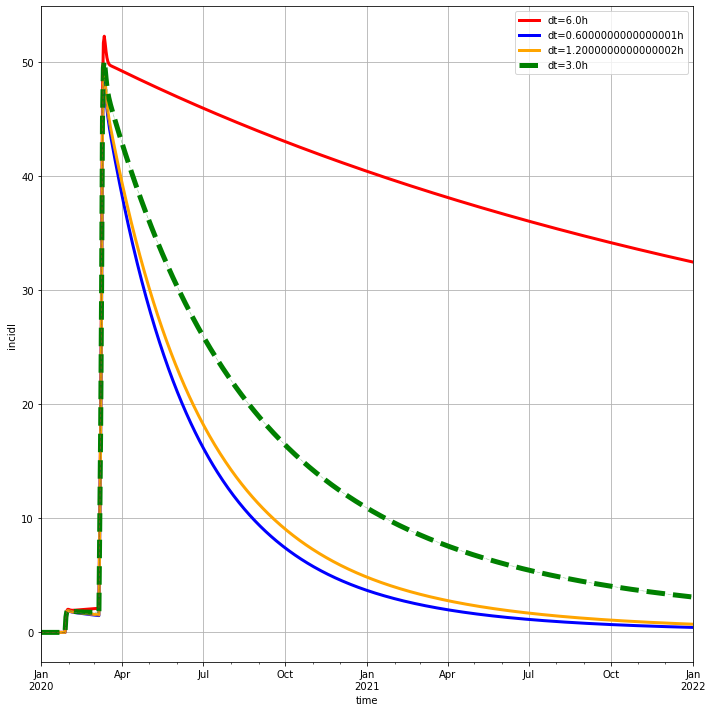

In [5]:
fig, axes = plt.subplots(1,1, figsize=(10,10), facecolor='white')
ax=axes
ax.grid()
#ax.set_xlabel('scaled blocks')
ax.set_ylabel('incidI')

fn = 'model_output/seir/USA/inference/med/R7_lowVac_highVar_drop_incidC_CA-WA/global/final/000000001.R7_lowVac_highVar_drop_incidC_CA-WA.seir.parquet'
df = pq.read_table(fn).to_pandas()
df_orig=df[df['comp']=='diffI'].groupby('time').sum()['53000']
#df_orig.plot(label='CA-WA run', ax = ax, c = 'darkgreen', lw=6)

df_dt1.mean(axis=1).plot(label=f'dt={dt1*24}h', ax = ax, c = 'red', lw=3)
df_dt2.mean(axis=1).plot(label=f'dt={dt2*24}h', ax = ax, c = 'blue', lw=3)
df_dt3.mean(axis=1).plot(label=f'dt={dt3*24}h', ax = ax, c = 'orange', lw=3)
df_dt4.mean(axis=1).plot(label=f'dt={dt4*24}h', ax = ax, c = 'green', lw=5, ls = '--')
ax.legend()
df_dt2.plot(legend=False, lw = .5, c = 'blue', ax=ax, linestyle = '-.', alpha = .5)
df_dt1.plot(legend=False, lw = .5, c = 'red', ax=ax, linestyle = '-.', alpha = .5)
df_dt3.plot(legend=False, lw = .5, c = 'orange', ax=ax, linestyle = '-.', alpha = .5)
df_dt4.plot(legend=False, lw = .5, c = 'green', ax=ax, linestyle = '-.', alpha = .5)

ax.grid()

fig.tight_layout()